In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
import torch
import numpy as np
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim


In [3]:
import cv2

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32 , kernel_size=7, padding=1, stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32 , kernel_size=7, padding=1, stride=(1,1))
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.pad = nn.ZeroPad2d((3, 3))
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(4160,10)

    def forward(self, x):
       
        x = self.pad(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 4160)
        x = self.fc(x)
        
        return x

In [7]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [14]:
def train():
    mnist_train = datasets.MNIST('./', train=True, download=True, transform=transforms.ToTensor())
    mnist_test= datasets.MNIST('./', train=False, download=True, transform=transforms.ToTensor())
    cnn = CNN().to(device)

    loss_plot = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)

    batch_size = 1

    trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

    accur = []
    for epoch in range(5):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = cnn(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:    # print every 1000 batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                loss_plot.append(running_loss)
                running_loss = 0.0

        acc = []
        for j, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = cnn(inputs)
            acc.append(accuracy(outputs, labels))
        print(torch.stack(acc).mean())
        accur.append(torch.stack(acc).mean())
    print('Finished Training, saving')
    #torch.save(cnn, '/content/drive/My Drive/ML4NS1/cnn_mnist')
    print("Saved")
    plt.plot(loss_plot)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[1,  1000] loss: 0.935
[1,  2000] loss: 0.316
[1,  3000] loss: 0.223
[1,  4000] loss: 0.206
[1,  5000] loss: 0.137
[1,  6000] loss: 0.144
[1,  7000] loss: 0.141
[1,  8000] loss: 0.143
[1,  9000] loss: 0.155
[1, 10000] loss: 0.134
[1, 11000] loss: 0.120
[1, 12000] loss: 0.127
[1, 13000] loss: 0.109
[1, 14000] loss: 0.114
[1, 15000] loss: 0.105
[1, 16000] loss: 0.080
[1, 17000] loss: 0.089
[1, 18000] loss: 0.084
[1, 19000] loss: 0.059
[1, 20000] loss: 0.080
[1, 21000] loss: 0.062
[1, 22000] loss: 0.062
[1, 23000] loss: 0.105
[1, 24000] loss: 0.067
[1, 25000] loss: 0.053
[1, 26000] loss: 0.084
[1, 27000] loss: 0.098
[1, 28000] loss: 0.064
[1, 29000] loss: 0.089
[1, 30000] loss: 0.058
[1, 31000] loss: 0.078
[1, 32000] loss: 0.078
[1, 33000] loss: 0.029
[1, 34000] loss: 0.076
[1, 35000] loss: 0.068
[1, 36000] loss: 0.085
[1, 37000] loss: 0.075
[1, 38000] loss: 0.058
[1, 39000] loss: 0.052
[1, 40000] loss: 0.044
[1, 41000] loss: 0.082
[1, 42000] loss: 0.070
[1, 43000] loss: 0.061
[1, 44000] 

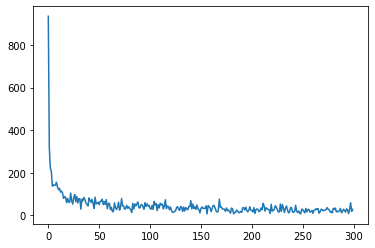

In [16]:
train()

In [ ]:
train_data0 = np.load('/content/drive/My Drive/ML4NS1/data0.npy')
train_lab0 = np.load('/content/drive/My Drive/ML4NS1/lab0.npy')
train_data1 = np.load('/content/drive/My Drive/ML4NS1/data1.npy')
train_lab1 = np.load('/content/drive/My Drive/ML4NS1/lab1.npy')
train_data2 = np.load('/content/drive/My Drive/ML4NS1/data2.npy')
train_lab2 = np.load('/content/drive/My Drive/ML4NS1/lab2.npy')

train_data = np.concatenate((train_data0, train_data1, train_data2))
train_lab = np.concatenate((train_lab0, train_lab1, train_lab2))




In [ ]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img


In [ ]:
def split(image):
    ret, thresh = cv2.threshold(image,50,150,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    connectivity = 8  
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    stats = output[2]
    segments = []
    for i in range(1,len(stats)):
        l,t,w,h,a = stats[i]
        cropped = image[t:t+h,l:l+w]
        if a >= 30:
            if w > 22 and w<=37:
                splitted1=image[t:t+h, l:l+int(w/2)]
                splitted2=image[t:t+h, l+int(w/2):l+w]

                splitted1 = cv2.resize(splitted1, (0,0), fx=0.78, fy=0.78, interpolation = cv2.INTER_AREA) 
                splitted2 = cv2.resize(splitted2, (0,0), fx=0.78, fy=0.78, interpolation = cv2.INTER_AREA)


                pad_shape = np.array([28, 28]) - np.array(splitted1.shape)
                splitted1 = np.pad(splitted1, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                splitted1 = deskew(splitted1)
                segments.append(splitted1)

                pad_shape = np.array([28, 28]) - np.array(splitted2.shape)
                splitted2 = np.pad(splitted2, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                splitted2 = deskew(splitted2)
                segments.append(splitted2)
            
            elif w>37:
                splitted1=image[t:t+h, l:l+int(w/3)]
                splitted2=image[t:t+h, l+int(w/3):l+int(2*w/3)]
                splitted3=image[t:t+h, l+int(2*w/3):l+w]

                splitted1 = cv2.resize(splitted1, (0,0), fx=0.78, fy=0.78, interpolation = cv2.INTER_AREA) 
                splitted2 = cv2.resize(splitted2, (0,0), fx=0.78, fy=0.78, interpolation = cv2.INTER_AREA)
                splitted3 = cv2.resize(splitted3, (0,0), fx=0.78, fy=0.78, interpolation = cv2.INTER_AREA)


                pad_shape = np.array([28, 28]) - np.array(splitted1.shape)
                splitted1 = np.pad(splitted1, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                splitted1 = deskew(splitted1)
                segments.append(splitted1)

                pad_shape = np.array([28, 28]) - np.array(splitted2.shape)
                splitted2 = np.pad(splitted2, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                splitted2 = deskew(splitted2)
                segments.append(splitted2)

                pad_shape = np.array([28, 28]) - np.array(splitted3.shape)
                splitted3 = np.pad(splitted3, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                splitted3 = deskew(splitted3)
                segments.append(splitted3)

            else:
                if h>28:
                    cropped = cv2.resize(cropped, (0,0), fx=0.8, fy=0.8, interpolation = cv2.INTER_AREA)
                pad_shape = np.array([28, 28]) - np.array(cropped.shape)
                cropped = np.pad(cropped, ((pad_shape[0] // 2, (pad_shape[0] + 1) // 2), (pad_shape[1] // 2, (pad_shape[1] + 1) // 2)))
                cropped = deskew(cropped)
                segments.append(cropped)
    return segments
    

In [ ]:
def predict(model_path, train_data, train_lab):
    predictor = torch.load(model_path)
    predictor.to(device)
    acc = []
    counter = 0
    falsectr = 0
    for i in range(len(train_data)):
        img = train_data[i]
        labels = train_lab[i]     
        inputs = split(img)
        sum = 0
        digits = []
        for j in range(len(inputs)):
            image = torch.from_numpy(inputs[j])
            image = torch.reshape(image, (1,1,28,28)).float()
            outputs = predictor(image.to(device))
            digit = torch.argmax(outputs)
            digits.append(digit)
            sum += digit
        if sum == labels:
            counter+=1
        if i % 500 == 499:    # print every 5000
                print('%d, accuracy: %.3f' %
                        ( i+1, counter*100 / i))
    print("Final accuracy "+str(counter*100/len(train_data))+"%")


In [ ]:
predict('/content/drive/My Drive/ML4NS1/cnn_mnist',  train_data, train_lab)

500, accuracy: 63.928
1000, accuracy: 64.765
1500, accuracy: 64.243
2000, accuracy: 63.582
2500, accuracy: 62.745
3000, accuracy: 63.288
3500, accuracy: 63.818
4000, accuracy: 64.241
4500, accuracy: 64.570
5000, accuracy: 64.333
5500, accuracy: 64.394
6000, accuracy: 64.061
6500, accuracy: 63.933
7000, accuracy: 63.952
7500, accuracy: 63.742
8000, accuracy: 63.620
8500, accuracy: 63.607
9000, accuracy: 63.396
9500, accuracy: 63.459
10000, accuracy: 63.436
10500, accuracy: 63.397
11000, accuracy: 63.451
11500, accuracy: 63.449
12000, accuracy: 63.514
12500, accuracy: 63.397
13000, accuracy: 63.336
13500, accuracy: 63.345
14000, accuracy: 63.226
14500, accuracy: 63.184
15000, accuracy: 63.198
15500, accuracy: 63.223
16000, accuracy: 63.298
16500, accuracy: 63.319
17000, accuracy: 63.286
17500, accuracy: 63.284
18000, accuracy: 63.381
18500, accuracy: 63.355
19000, accuracy: 63.340
19500, accuracy: 63.388
20000, accuracy: 63.308
20500, accuracy: 63.330
21000, accuracy: 63.246
21500, accur